# HTesterGUI Jitter Measuremet
BER tail fit theory and experiment

Holger.Steffens@schleifring.de, 23.03.2021

## Scipy `special.erf()` and `special.erfinv`

In [1]:
from scipy import special
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

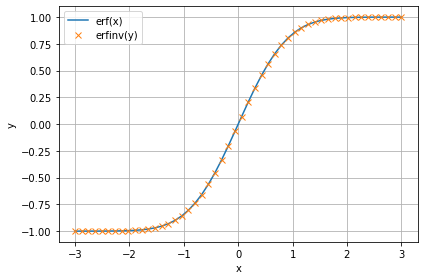

In [2]:
x = np.linspace(-3, 3)
erf_y = special.erf(x)
plt.plot(x, erf_y, label="erf(x)")
erfinv_x = special.erfinv(erf_y)
plt.plot(erfinv_x, erf_y, "x", label="erfinv(y)")
plt.xlabel("x"), plt.ylabel("y")
plt.legend(), plt.tight_layout(), plt.grid();

## Scipy `special.erfcinv`

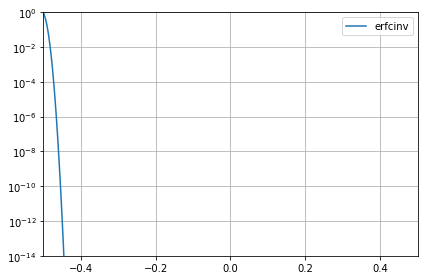

In [3]:
ymin = -14
y = 10**np.linspace(0, ymin)
x = special.erfcinv(y)*0.01 - 0.5
plt.semilogy(x, y, label="erfcinv")
plt.xlim([-0.5, 0.5]), plt.ylim([10**ymin, 1])
plt.legend(), plt.tight_layout(), plt.grid();

## Scipy curve fit
Understanding the tutorial from https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.curve_fit.html

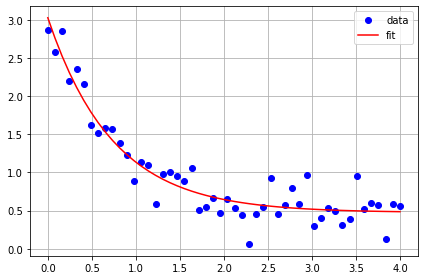

In [4]:
from scipy.optimize import curve_fit

def func(x, a, b, c):
    return a * np.exp(-b * x) + c

xdata = np.linspace(0, 4, 50)
y = func(xdata, 2.5, 1.3, 0.5)
np.random.seed(1729)
y_noise = 0.2 * np.random.normal(size=xdata.size)
ydata = y + y_noise
plt.plot(xdata, ydata, 'bo', label='data');

popt, pcov = curve_fit(func, xdata, ydata)

plt.plot(xdata, func(xdata, *popt), 'r-', label='fit')

plt.grid(), plt.legend(), plt.tight_layout();

In [5]:
popt

array([2.55423706, 1.35190947, 0.47450618])

In [6]:
pcov

array([[ 0.0158905 ,  0.00681778, -0.0007614 ],
       [ 0.00681778,  0.02019919,  0.00541905],
       [-0.0007614 ,  0.00541905,  0.00282595]])

## Scipy fit linear function to HTester data

In [7]:
meas_data = pd.DataFrame({'HORZ_OFFS': [-0.28125, -0.265625, -0.25],
                          'BER': [4.15808e-05, 3.33791e-07, 3.725347e-09]})
meas_data

,HORZ_OFFS,BER
0,-0.281250,4.158080e-05
1,-0.265625,3.337910e-07
2,-0.250000,3.725347e-09


In [8]:
def max_lin_func(*args):
    """
    Simple experimental jitter fitting function
    Linear in log BER space with clipping at MAX_BER    
    """
    def lin_func(x, m, b):
        return 10**(m * x + b)

    MAX_BER = 0.5
    
    return np.minimum(MAX_BER, lin_func(*args))

In [9]:
popt, _ = curve_fit(max_lin_func, meas_data["HORZ_OFFS"], meas_data["BER"])
print("fit resuls:\n m={}\n b={}".format(*popt))

ValueError: Unable to determine number of fit parameters.

In [ ]:
x = np.linspace(-0.5, 0)
plt.semilogy(x, max_lin_func(x, *popt), label="max_lin_func")
plt.semilogy(meas_data["HORZ_OFFS"], meas_data["BER"], "bo", label="meas_data")
plt.ylim([10**-14, 1])
plt.legend(), plt.tight_layout(), plt.grid();

## Scipy fit `erfcinf` function to HTester data

In [ ]:
def jitter_func(ber, rj, dj):
    """
    Jitter model function based on scipy inverse complemetary error function 
      input <np.array> ber: bit error ratio data from the HTester
      input <float> rj: Random jitter component. Width of the gaussian distribution. 
      input <float> dj: Determinitstic jitter. Offset of the gaussian distribution. 
      return <np.array> horz_offs: sample points within the unit interval
    scipy inverse complemetary error function doc:
    https://docs.scipy.org/doc/scipy/reference/generated/scipy.special.erfcinv.html?highlight=erfcinv
    """
    return special.erfcinv(ber) * np.sqrt(2) * rj + dj

In [ ]:
params, _ = curve_fit(jitter_func, meas_data["BER"], meas_data["HORZ_OFFS"], p0=[0.02, -0.4])
print("fit resuls:\n  RJ_rms = {:.4f}\n  DJ_pk = {:.4f}".format(*params))

In [ ]:
plt.semilogy(meas_data["HORZ_OFFS"], meas_data["BER"], "bo", label="meas_data")
y = 10**np.linspace(-3, -14)
plt.semilogy(jitter_func(y, *params), y, label="jitter_func")
plt.xlim([-0.5, 0]), plt.ylim([10**-14, 1])
plt.legend(), plt.tight_layout(), plt.grid();

#### Calculate TJpp @BERS=1E-12

In [ ]:
TJ_pk = jitter_func(1E-12, *params) - (-0.5)
TJ_pp = 2 * TJ_pk
TJ_pp